In [1]:
# 
using TableTraits
import Tables,Tables.columnindex
using Random
abstract type AbstractIndex end

struct Index <: AbstractIndex
    lookup::Dict{Symbol, Int}
    names::Vector{Symbol}
end

function Index(names::AbstractVector{Symbol}; makeunique::Bool=false)
    u = make_unique(names, makeunique=makeunique)
    lookup = Dict{Symbol, Int}(zip(u, 1:length(u)))
    return Index(lookup, u)
end

Index() = Index(Dict{Symbol, Int}(), Symbol[])
Base.length(x::Index) = length(x.names)
Base.names(x::Index) = string.(x.names)

#make_unique方法
function make_unique(names::AbstractVector{Symbol}; makeunique::Bool=false)
    make_unique!(similar(names), names, makeunique=makeunique)
end

function make_unique!(names::Vector{Symbol}, src::AbstractVector{Symbol};
                      makeunique::Bool=false)
    if length(names) != length(src)
        throw(DimensionMismatch("Length of src doesn't match length of names."))
    end
    seen = Set{Symbol}()
    dups = Int[]
    for i in 1:length(names)
        name = src[i]
        if in(name, seen)
            push!(dups, i)
        else
            names[i] = src[i]
            push!(seen, name)
        end
    end

    if length(dups) > 0
        if !makeunique
            dupstr = join(string.(':', unique(src[dups])), ", ", " and ")
            msg = "Duplicate variable names: $dupstr. Pass makeunique=true " *
                  "to make them unique using a suffix automatically."
            throw(ArgumentError(msg))
        end
    end

    for i in dups
        nm = src[i]
        k = 1
        while true
            newnm = Symbol("$(nm)_$k")
            if !in(newnm, seen)
                #如果已有已经见过的里面没有newnm的话...
                names[i] = newnm
                push!(seen, newnm)
                break
            end
            k += 1
        end
    end

    return names
end

make_unique! (generic function with 1 method)

In [2]:
abstract type AbstractDataFrame end
struct DataFrame <: AbstractDataFrame
    columns::Vector{AbstractVector}
    colindex::Index
    
    #内部构造器
    function DataFrame(columns::Union{Vector{Any}, Vector{AbstractVector}},
        colindex::Index; copycols::Bool=true)
        if length(columns) == length(colindex) == 0
            return new(AbstractVector[], Index())
        elseif length(columns) != length(colindex)
            throw(DimensionMismatch("Number of columns ($(length(columns))) and number of" *
                    " column names($(length(colindex)) are not equal"))
        end
        
        len = -1
        firstvec = -1
        # 判断每个向量的长度是否相等（逐行迭代过去）
        for (i, col) in enumerate(columns)
            if col isa AbstractVector
                if len == -1
                    len = length(col)
                    firstvec = i
                elseif len != length(col)
                    n1 = _names(colindex)[firstvec]
                    n2 = _names(colindex)[i]
                    throw(DimensionMismatch("column :$n1 has length $len and column " *
                                            ":$n2 has length $(length(col))"))
                end
            end
        end
        # 如果len长度并没有边，那么说明，生成的是一个标量
        len == -1 && (len = 1)

        # we write into columns as we know that it is guaranteed
        # that it was freshly allocated in the outer constructor
        for (i, col) in enumerate(columns)
            # check for vectors first as they are most common
            if col isa AbstractRange
                columns[i] = collect(col)
            elseif col isa AbstractVector
                columns[i] = copycols ? copy(col) : col
            elseif col isa Union{AbstractArray{<:Any, 0}, Ref}
                x = col[]
                columns[i] = fill!(Tables.allocatecolumn(typeof(x), len), x)
            else
                if col isa AbstractArray
                    throw(ArgumentError("adding AbstractArray other than AbstractVector" *
                                        " as a column of a data frame is not allowed"))
                end
                columns[i] = fill!(Tables.allocatecolumn(typeof(col), len), col)
            end
        end

        new(convert(Vector{AbstractVector}, columns), colindex)
    end
end

#参数和值，装箱
function DataFrame(; kwargs...)
    if isempty(kwargs)
        DataFrame([], Index())
    else
        cnames = Symbol[]
        columns = Any[]
        copycols = true
        for (kw, val) in kwargs
            if kw == :copycols
                if val isa Bool
                    copycols = val
                else
                    throw(ArgumentError("the `copycols` keyword argument must be Boolean"))
                end
            else
                push!(cnames, kw)
                push!(columns, val)
            end
        end
        DataFrame(columns, Index(cnames), copycols=copycols)
    end
end



DataFrame

In [5]:
using Printf

# 字典构造法
function DataFrame(d::AbstractDict; copycols::Bool=true)
    if isa(d, Dict)
        colnames = sort!(collect(keys(d)))
    else
        colnames = keys(d)
    end
    colindex = Index([Symbol(k) for k in colnames])
    columns = Any[d[c] for c in colnames]
    DataFrame(columns, colindex, copycols = copycols)
end

# 应对字典对
function DataFrame(pairs::Pair{Symbol,<:Any}...;makeunique::Bool=false,
    copycols::Bool=true)::DataFrame
    colnames = [Symbol(k) for (k, v) in pairs]
    columns = Any[v for (k, v) in pairs]
    return DataFrame(columns, Index(colnames, makeunique=makeunique), copycols=copycols)
end

# 应对纯Pairs
function DataFrame(pairs::Pair{<:AbstractString,<:Any}...; makeunique::Bool=false,
                   copycols::Bool=true)::DataFrame
    colnames = [Symbol(k) for (k,v) in pairs]
    columns = Any[v for (k,v) in pairs]
    return DataFrame(columns, Index(colnames, makeunique=makeunique),
                     copycols=copycols)
end

DataFrame(pairs::AbstractVector{<:Pair}; makeunique::Bool=false,
    copycols::Bool=true) = 
    DataFrame(pairs..., makeunique=makeunique, copycols=copycols)

function gennames(n::Integer)
    res = Vector{Symbol}(undef, n)
    for i in 1:n
        res[i] = Symbol(@sprintf "x%d" i)
    end
    return res
end

DataFrame(columns::AbstractVector{<:AbstractVector},
          cnames::AbstractVector{Symbol}=gennames(length(columns));
          makeunique::Bool=false, copycols::Bool=true)::DataFrame =
    DataFrame(collect(AbstractVector, columns),
              Index(convert(Vector{Symbol}, cnames), makeunique=makeunique),
              copycols=copycols)

DataFrame(columns::AbstractVector{<:AbstractVector},
          cnames::AbstractVector{<:AbstractString};
          makeunique::Bool=false, copycols::Bool=true) =
    DataFrame(columns, Symbol.(cnames); makeunique=makeunique, copycols=copycols)

DataFrame

In [24]:
DataFrame(columns::AbstractVector{<:AbstractVector},
          cnames::AbstractVector{<:AbstractString};
          makeunique::Bool=false, copycols::Bool=true) =
    DataFrame(columns, Symbol.(cnames); makeunique=makeunique, copycols=copycols)

DataFrame(columns::NTuple{N, AbstractVector}, cnames::NTuple{N, Symbol};
          makeunique::Bool=false, copycols::Bool=true) where {N} =
    DataFrame(collect(AbstractVector, columns), collect(Symbol, cnames),
              makeunique=makeunique, copycols=copycols)

DataFrame(columns::NTuple{N, AbstractVector}, cnames::NTuple{N, AbstractString};
          makeunique::Bool=false, copycols::Bool=true) where {N} =
    DataFrame(columns, Symbol.(cnames); makeunique=makeunique, copycols=copycols)

DataFrame(columns::NTuple{N, AbstractVector}; copycols::Bool=true) where {N} =
    DataFrame(collect(AbstractVector, columns), gennames(length(columns)),
              copycols=copycols)

DataFrame(columns::AbstractMatrix,
          cnames::AbstractVector{Symbol} = gennames(size(columns, 2));
          makeunique::Bool=false) =
    DataFrame(AbstractVector[columns[:, i] for i in 1:size(columns, 2)], cnames,
              makeunique=makeunique, copycols=false)

DataFrame(columns::AbstractMatrix, cnames::AbstractVector{<:AbstractString};
          makeunique::Bool=false) =
    DataFrame(columns, Symbol.(cnames); makeunique=makeunique)

function DataFrame(column_eltypes::AbstractVector{T}, cnames::AbstractVector{Symbol},
                   nrows::Integer=0; makeunique::Bool=false)::DataFrame where T<:Type
    columns = AbstractVector[elty >: Missing ?
                             fill!(Tables.allocatecolumn(elty, nrows), missing) :
                             Tables.allocatecolumn(elty, nrows)
                             for elty in column_eltypes]
    return DataFrame(columns, Index(convert(Vector{Symbol}, cnames),
                     makeunique=makeunique), copycols=false)
end

DataFrame(column_eltypes::AbstractVector{<:Type},
          cnames::AbstractVector{<:AbstractString},
          nrows::Integer=0; makeunique::Bool=false) =
    DataFrame(column_eltypes, Symbol.(cnames), nrows; makeunique=makeunique)

DataFrame

In [14]:
getvector(x::AbstractVector) = x
getvector(x) = [x[i] for i = 1:length(x)]
# note that copycols is ignored in this definition (Tables.CopiedColumns implies copies have already been made)
fromcolumns(x::Tables.CopiedColumns, names; copycols::Bool=true) =
    DataFrame(AbstractVector[getvector(Tables.getcolumn(x, nm)) for nm in names],
              Index(names),
              copycols=false)
fromcolumns(x, names; copycols::Bool=true) =
    DataFrame(AbstractVector[getvector(Tables.getcolumn(x, nm)) for nm in names],
              Index(names),
              copycols=copycols)

DataFrame(x::AbstractVector{NamedTuple{names, T}}; copycols::Bool=true) where {names, T} =
    fromcolumns(Tables.columns(Tables.IteratorWrapper(x)), collect(names), copycols=false)
DataFrame!(x::AbstractVector{<:NamedTuple}) =
    throw(ArgumentError("It is not possible to construct a `DataFrame` from " *
                        "`$(typeof(x))` without allocating new columns: use " *
                        "`DataFrame(x)` instead"))
"""
function DataFrame(x::T; copycols::Bool=true) where {T}
    if !Tables.istable(x)
        if x isa AbstractVector && all(col -> isa(col, AbstractVector), x)
            return DataFrame(Vector{AbstractVector}(x), copycols=copycols)
        elseif (x isa AbstractVector || x isa Tuple) &&
            all(v -> v isa Pair{Symbol, <:AbstractVector}, x)
            return DataFrame(AbstractVector[last(v) for v in x], [first(v) for v in x],
                             copycols=copycols)
        end
    end
    cols = Tables.columns(x)
    names = collect(Symbol, Tables.columnnames(cols))
    return fromcolumns(cols, names, copycols=copycols)
end
"""

"function DataFrame(x::T; copycols::Bool=true) where {T}\n    if !Tables.istable(x)\n        if x isa AbstractVector && all(col -> isa(col, AbstractVector), x)\n            return DataFrame(Vector{AbstractVector}(x), copycols=copycols)\n        elseif (x isa AbstractVector || x isa Tuple) &&\n            all(v -> v isa Pair{Symbol, <:AbstractVector}, x)\n            return DataFrame(AbstractVector[last(v) for v in x], [first(v) for v in x],\n                             copycols=copycols)\n        end\n    end\n    cols = Tables.columns(x)\n    names = collect(Symbol, Tables.columnnames(cols))\n    return fromcolumns(cols, names, copycols=copycols)\nend\n"

In [16]:
v = [(a=1, b=2), (a=3, b=4)]
DataFrame(v)

DataFrame(AbstractArray{T,1} where T[[1, 3], [2, 4]], Index(Dict(:a => 1,:b => 2), [:a, :b]))

In [25]:
n = (a=1:3, b=11:13)
cols = Tables.columns(n)
names = collect(Symbol, Tables.columnnames(cols))
fromcolumns(cols, names, true)

MethodError: MethodError: no method matching fromcolumns(::NamedTuple{(:a, :b),Tuple{UnitRange{Int64},UnitRange{Int64}}}, ::Array{Symbol,1}, ::Bool)
Closest candidates are:
  fromcolumns(::Any, ::Any; copycols) at In[14]:8
  fromcolumns(!Matched::Tables.CopiedColumns, ::Any; copycols) at In[14]:4

In [23]:
Tables.istable(n)

true

In [13]:
x = Dict("A" => [1,2], "B" => [true, false], "C" => ['a', 'b'], "fixed" => Ref([1,1]), "E" => 3)
DataFrame(x)

DataFrame(AbstractArray{T,1} where T[[1, 2], Bool[1, 0], ['a', 'b'], [3, 3], [[1, 1], [1, 1]]], Index(Dict(:A => 1,:B => 2,:E => 4,:fixed => 5,:C => 3), [:A, :B, :C, :E, :fixed]))

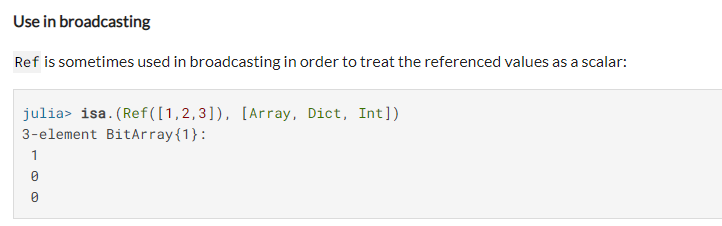

In [6]:
DataFrame(:A => [1,2], :B => [true, false], :C => ['a', 'b'])
DataFrame("A" => [1,2], "B" => [true, false], "C" => ['a', 'b'])

DataFrame(AbstractArray{T,1} where T[[1, 2], Bool[1, 0], ['a', 'b']], Index(Dict(:A => 1,:B => 2,:C => 3), [:A, :B, :C]))

In [7]:
# 测试用格子
DataFrame()

DataFrame(AbstractArray{T,1} where T[], Index(Dict{Symbol,Int64}(), Symbol[]))

In [8]:
DataFrame(A=1:3, B = rand(3), C = randstring.([3,3,3]), fixed=1)

DataFrame(AbstractArray{T,1} where T[[1, 2, 3], [0.2739700053780385, 0.5249676727208521, 0.4173230733419666], ["Y2Z", "1ce", "S8H"], [1, 1, 1]], Index(Dict(:A => 1,:B => 2,:fixed => 4,:C => 3), [:A, :B, :C, :fixed]))

In [9]:
Index([:A, :B, :C])

Index(Dict(:A => 1,:B => 2,:C => 3), [:A, :B, :C])

In [10]:

make_unique([:A, :B, :C, :C, :C], makeunique = true)

5-element Array{Symbol,1}:
 :A
 :B
 :C
 :C_1
 :C_2

In [7]:
similar([:A, :B, :C])

3-element Array{Symbol,1}:
 #undef
 #undef
 #undef

In [15]:
length([1:3, rand(3), randstring.([3, 3, 3])])

3

In [16]:
collect(1:5)

5-element Array{Int64,1}:
 1
 2
 3
 4
 5

In [7]:

DataFrame(A=1:3, B = rand(3), C = randstring.([3,3,3]), fixed=1)

4-element Array{Any,1}:
  1:3
  [0.5682089873340079, 0.7522527439869477, 0.3310326664575929]
  ["cey", "10R", "zvH"]
 1

In [16]:
DataFrame([:A => [1,2], :B => [true, false], :C => ['a', 'b'], :fixed => "const"])

DataFrame(AbstractArray{T,1} where T[[1, 2], Bool[1, 0], ['a', 'b'], ["const", "const"]], Index(Dict(:A => 1,:B => 2,:fixed => 4,:C => 3), [:A, :B, :C, :fixed]))

In [11]:
DataFrame([rand(3) for i in 1:3])
DataFrame([rand(3) for i in 1:3], ["x1", "x2", "x3"])

DataFrame(AbstractArray{T,1} where T[[0.8011303180320688, 0.028002009875943923, 0.5794336039929853], [0.9165361974149973, 0.4878499486420882, 0.8657550362876756], [0.7440283599740685, 0.6322208593216627, 0.5578281555374671]], Index(Dict(:x2 => 2,:x3 => 3,:x1 => 1), [:x1, :x2, :x3]))

In [12]:
v = [(a=1, b=2), (a=3, b=4)]
DataFrame(v)

MethodError: MethodError: no method matching DataFrame(::Array{NamedTuple{(:a, :b),Tuple{Int64,Int64}},1})
Closest candidates are:
  DataFrame(; kwargs...) at In[2]:61
  DataFrame(!Matched::Union{Array{AbstractArray{T,1} where T,1}, Array{Any,1}}, !Matched::Index; copycols) at In[2]:9
  DataFrame(!Matched::AbstractDict; copycols) at In[5]:5
  ...

In [27]:
DataFrame(A=Int[], B=Float64[], C=String[])

DataFrame(AbstractArray{T,1} where T[Int64[], Float64[], String[]], Index(Dict(:A => 1,:B => 2,:C => 3), [:A, :B, :C]))

In [29]:
Tables.columns(v)

Tables.CopiedColumns{NamedTuple{(:a, :b),Tuple{Array{Int64,1},Array{Int64,1}}}}: (a = [1, 3], b = [2, 4])

In [31]:
tem = DataFrame(rand(3,4), string.('a':'d'))
tem.colindex

Index(Dict(:a => 1,:b => 2,:d => 4,:c => 3), [:a, :b, :c, :d])

## 回顾基类
> 文件组织
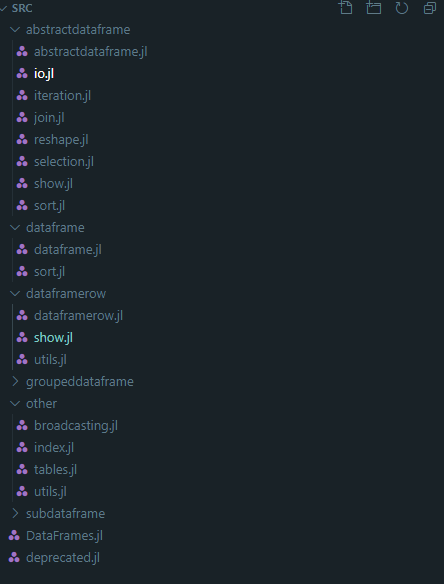

In [42]:
# 3.getindex
#const SymbolOrString = Union{Symbol, AbstractString}
const ColumnIndex = Union{Signed, Unsigned, SymbolOrString}
const MultiColumnIndex = Union{AbstractVector, Regex, Not, Between, All, Colon}
const MULTICOLUMNINDEX_TUPLE = (:AbstractVector, :Regex, :Not, :Between, :All, :Colon)

const COLUMNINDEX_STR = "`Symbol`, string or integer"
const MULTICOLUMNINDEX_STR = "`:`, `All`, `Between`, `Not`, a regular expression," *
                          " or a vector of `Symbol`s, strings or integers"

# df[SingleRowIndex, SingleColumnIndex] => Scalar
@inline function Base.getindex(df::DataFrame, row_ind::Integer,
                               col_ind::Union{Signed, Unsigned})
    cols = _columns(df)
    @boundscheck begin
        if !checkindex(Bool, axes(cols, 1), col_ind)
            throw(BoundsError(df, (row_ind, col_ind)))
        end
        if !checkindex(Bool, axes(df, 1), row_ind)
            throw(BoundsError(df, (row_ind, col_ind)))
        end
    end

    @inbounds cols[col_ind][row_ind]
end

@inline function Base.getindex(df::DataFrame, row_ind::Integer,
                               col_ind::SymbolOrString)
    selected_column = index(df)[col_ind]
    @boundscheck if !checkindex(Bool, axes(df, 1), row_ind)
        throw(BoundsError(df, (row_ind, col_ind)))
    end
    @inbounds _columns(df)[selected_column][row_ind]
end

# df[MultiRowIndex, SingleColumnIndex] => AbstractVector, copy
@inline function Base.getindex(df::DataFrame, row_inds::AbstractVector, col_ind::ColumnIndex)
    selected_column = index(df)[col_ind]
    @boundscheck if !checkindex(Bool, axes(df, 1), row_inds)
        throw(BoundsError(df, (row_inds, col_ind)))
    end
    @inbounds return _columns(df)[selected_column][row_inds]
end

@inline Base.getindex(df::DataFrame, row_inds::Not, col_ind::ColumnIndex) =
    df[axes(df, 1)[row_inds], col_ind]

# df[:, SingleColumnIndex] => AbstractVector
function Base.getindex(df::DataFrame, row_inds::Colon, col_ind::ColumnIndex)
    selected_column = index(df)[col_ind]
    copy(_columns(df)[selected_column])
end

# df[!, SingleColumnIndex] => AbstractVector, the same vector
@inline function Base.getindex(df::DataFrame, ::typeof(!), col_ind::Union{Signed, Unsigned})
    cols = _columns(df)
    @boundscheck if !checkindex(Bool, axes(cols, 1), col_ind)
        throw(BoundsError(df, (!, col_ind)))
    end
    @inbounds cols[col_ind]
end

function Base.getindex(df::DataFrame, ::typeof(!), col_ind::SymbolOrString)
    selected_column = index(df)[col_ind]
    return _columns(df)[selected_column]
end

# df[MultiRowIndex, MultiColumnIndex] => DataFrame
@inline function Base.getindex(df::DataFrame, row_inds::AbstractVector{T},
                               col_inds::MultiColumnIndex) where T
    @boundscheck if !checkindex(Bool, axes(df, 1), row_inds)
        throw(BoundsError(df, (row_inds, col_inds)))
    end
    selected_columns = index(df)[col_inds]
    # Computing integer indices once for all columns is faster
    selected_rows = T === Bool ? findall(row_inds) : row_inds
    new_columns = AbstractVector[dv[selected_rows] for dv in _columns(df)[selected_columns]]
    return DataFrame(new_columns, Index(_names(df)[selected_columns]), copycols=false)
end

@inline function Base.getindex(df::DataFrame, row_inds::AbstractVector{T}, ::Colon) where T
    @boundscheck if !checkindex(Bool, axes(df, 1), row_inds)
        throw(BoundsError(df, (row_inds, :)))
    end
    # Computing integer indices once for all columns is faster
    selected_rows = T === Bool ? findall(row_inds) : row_inds
    new_columns = AbstractVector[dv[selected_rows] for dv in _columns(df)]
    return DataFrame(new_columns, copy(index(df)), copycols=false)
end

@inline Base.getindex(df::DataFrame, row_inds::Not,
                      col_inds::MultiColumnIndex) =
    df[axes(df, 1)[row_inds], col_inds]

# df[:, MultiColumnIndex] => DataFrame
Base.getindex(df::DataFrame, row_ind::Colon,
              col_inds::MultiColumnIndex) =
    select(df, col_inds, copycols=true)

# df[!, MultiColumnIndex] => DataFrame
Base.getindex(df::DataFrame, row_ind::typeof(!),
              col_inds::MultiColumnIndex) =
    select(df, col_inds, copycols=false)

UndefVarError: UndefVarError: Not not defined

In [ ]:
# 其他的重要的dataframe方法

# 1.获取属性
index(df::DataFrame) = getfield(df, :colindex)
_columns(df::DataFrame) = getfield(df, :columns)

# 2.行数和列数
nrow(df::DataFrame) = ncol(df) > 0 ? length(_columns(df)[1])::Int : 0
ncol(df::DataFrame) = length(index(df))

#暂且跳过一致性检验(dataframe.jl 351)

# 3.getindex



# x.复制方法
function Base.copy(df::DataFrame; copycols::Bool=true)
    if copycols
        df[:, :]
    else
        DataFrame(eachcol(df), _names(df), copycols=false)
    end
end



In [36]:
x = DataFrame(a=1:2, b='a':'b')
getfield(x, :colindex)
#y = copy(x)

Index(Dict(:a => 1,:b => 2), [:a, :b])